In [1]:
#Notebook written by Miguel de Jesús Martínez Felipe and Divyanshu Singh 
# Quantum Euclidean Distance for Two Images
#https://github.com/Miguelillnino and https://github.com/divshacker

from qiskit import *
from qiskit.visualization import plot_histogram
from numpy import pi
from qiskit.circuit.library import QFT

#Libraries for Image Processing 
import numpy as np
import cv2
import matplotlib.pyplot as plt

C:\Users\MJMF2\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\MJMF2\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\MJMF2\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
def add_qubit(qc, q, sign = 1):
    if q > 3:
        sign = -sign
        
    for indx, qb in enumerate(range(8,12)):
        qc.cu1(sign * pi / (2**(3 - indx)), q, qb)
    

In [3]:
# For 2 qubits per image
# firstPart = 3
# secondPart = 1
# secondPart = secondPart -2
# firstPart = firstPart - 2

# For 4 qubits per image
# firstPart = 5
# secondPart = 1

def rotationsFourier(qc, sign = 1):
    qc.append(QFT(4), range(8,12))
    qPrima = 0
#   firstPart y secondPart, number of rotations
    firstPart = 5
    secondPart = 1
    for q in range(0,8):
        if q > 3:
            secondPart = secondPart -2
            qPrima = q + secondPart
        else:
            firstPart = firstPart - 2
            qPrima = q + firstPart
#         print(q)
        for index in range(0,2**qPrima):
            add_qubit(qc, q, sign)
            qc.barrier()
   
    qc.append(QFT(4,inverse=True), range(8,12)) #invQFT(4)

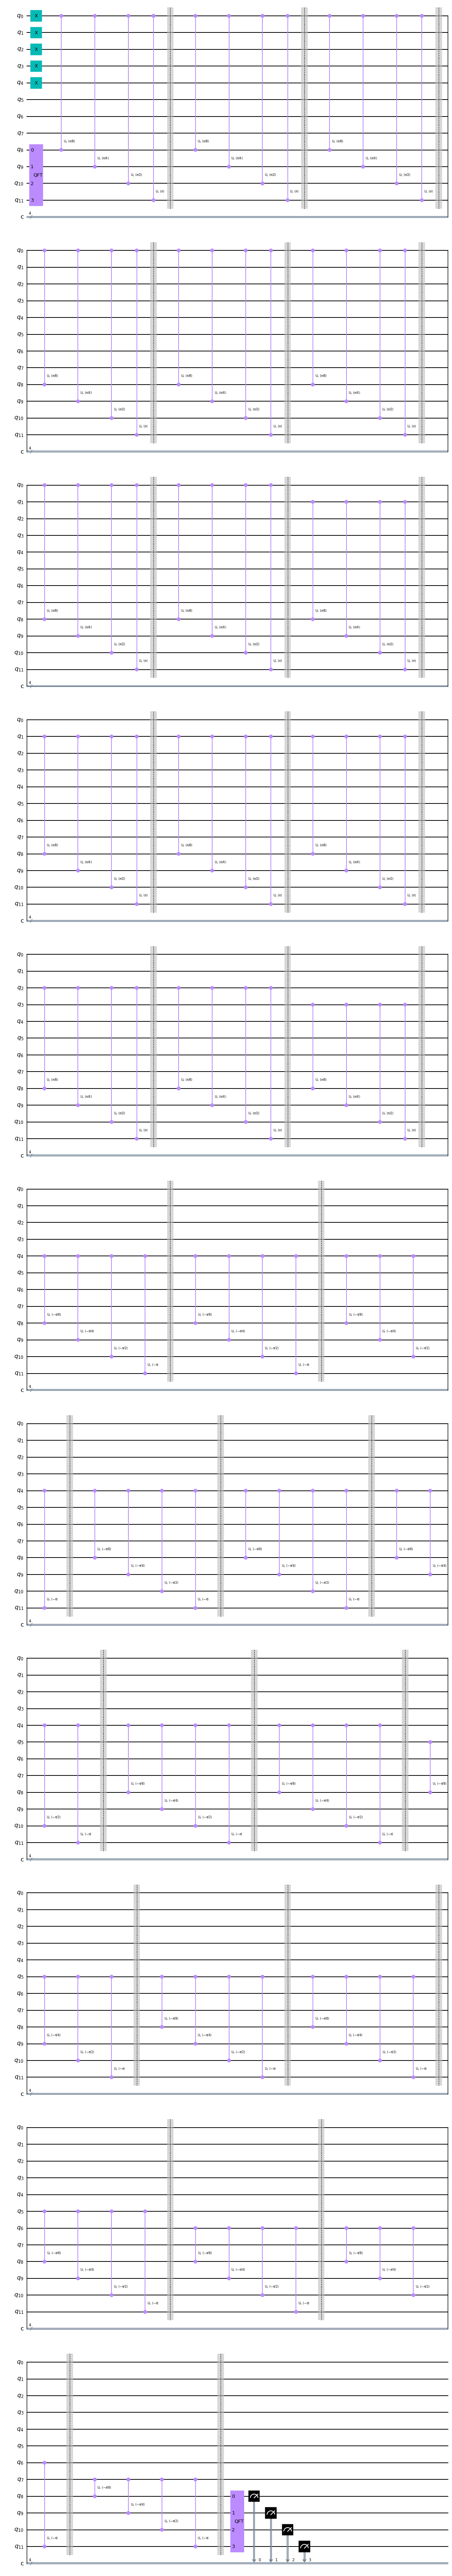

In [18]:
qc = QuantumCircuit(12,4)

# Pixeles de la primera imagen
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
# ------------------------------
# ------------------------------
# ------------------------------
# Pixeles de la segunda imagen
qc.x(4)

rotationsFourier(qc)

qc.measure(range(8,12), range(4))
#qc = qc.reverse_bits()
qc.draw('mpl')

In [5]:
qc.size()

131

In [6]:
qc.depth()

123

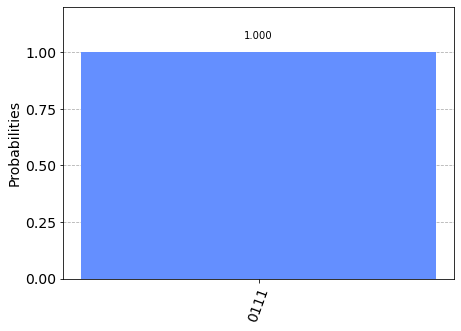

In [7]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots = 5)
plot_histogram(job.result().get_counts())


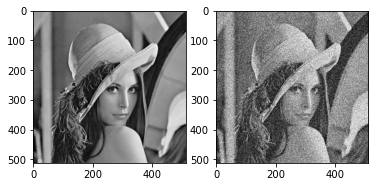

In [8]:
originalImage = cv2.imread('lena_gray.png')
grayOriginalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
noisyImage = cv2.imread('lena_gray_512_512_variance_400.png')
grayNoisyImage = cv2.cvtColor(noisyImage, cv2.COLOR_BGR2GRAY)
# print(grayoriginalImage)
plt.subplot(1,2,1)
plt.imshow(grayOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(grayNoisyImage, cmap='gray')
plt.show()

Original Image Dimensions :  (512, 512)
Resized Original Image Dimensions :  (64, 64)
Resized Noisy Image Dimensions :  (64, 64)


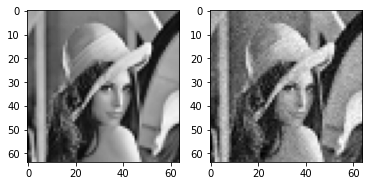

In [9]:
print('Original Image Dimensions : ',grayOriginalImage.shape) # Since images are 512x512 size
scale_percent = 12.5 # percent of original size for a 64x64 size
width = int(grayOriginalImage.shape[1] * scale_percent / 100)
height = int(grayOriginalImage.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize Original image
resizedOriginalImage = cv2.resize(grayOriginalImage, dim, interpolation = cv2.INTER_AREA)
print('Resized Original Image Dimensions : ',resizedOriginalImage.shape)
# resize Noisy image

resizedNoisyImage = cv2.resize(grayNoisyImage, dim, interpolation = cv2.INTER_AREA)
print('Resized Noisy Image Dimensions : ',resizedNoisyImage.shape)


plt.subplot(1,2,1)
plt.imshow(resizedOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(resizedNoisyImage, cmap='gray')
plt.show()

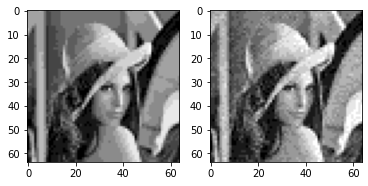

In [10]:
# Since we have a image of 8-bit pixel, make 256 rotations it not will be an option for a quantum circuit,
# so we use a 4-bit pixel from de 64x64 image
# originalImage64 = cv2.cvtColor(resizedOriginalImage, cv2.COLOR_BGR2GRAY) 
# noisyImage64 = cv2.cvtColor(resizedNoisyImage, cv2.COLOR_BGR2GRAY) 

[hight,lenght] = resizedOriginalImage.shape

# imagecopy= np.copy(grayimg64)
#Creamos el arreglo para la imagen Original de 64*64
arrayOriginalImage = np.arange(0, 4096, 1, np.uint8)
arrayOriginalImage = np.reshape(arrayOriginalImage, (64, 64))

#Creamos el arreglo para la imagen Ruidosa de 64*64
arrayNoisyImage = np.arange(0, 4096, 1, np.uint8)
arrayNoisyImage = np.reshape(arrayNoisyImage, (64, 64))

for altura in range(0,hight):
    for ancho in range (0,lenght):
        arrayOriginalImage[altura,ancho] = int(resizedOriginalImage[altura,ancho]/17)
        arrayNoisyImage[altura,ancho] = int(resizedNoisyImage[altura,ancho]/17)        
        
plt.subplot(1,2,1)
plt.imshow(arrayOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(arrayNoisyImage, cmap='gray')
plt.show()

In [11]:
def DevuelveStringCompleto(longValue,strignValue):
    resta = longValue - len(strignValue)
    Ceros = ''
    if resta !=0:
        for i in range(0,resta):
            Ceros += '0'      
    return Ceros+strignValue

In [12]:
listaCircuits = []
for i in range (0,arrayOriginalImage.shape[0]):
    for j in range (0,arrayOriginalImage.shape[1]):
        binaryPixelOne = bin(int(arrayOriginalImage[i,j]))
        binaryPixelTwo = bin(int(arrayNoisyImage[i,j]))
        CompleteBinaryOne = DevuelveStringCompleto(4,binaryPixelOne[2:len(binaryPixelOne)])
        CompleteBinaryTwo = DevuelveStringCompleto(4,binaryPixelTwo[2:len(binaryPixelTwo)])
        valueBinaryOne = str(CompleteBinaryOne)
        valueBinaryOTwo = str(CompleteBinaryTwo)

# Pixeles from Fisrt Image
# ------------------------------
# ------------------------------
# ------------------------------
# ------------------------------
        qc = QuantumCircuit(13,5)
        for idx, px_value in enumerate(valueBinaryOne[::1]):
            if(px_value=='1'):
                qc.x(idx)
                
# Pixels from Second Image
# ------------------------------
# ------------------------------
# ------------------------------
# ------------------------------

        for idy, py_value in enumerate(valueBinaryOTwo[::1]):
            if(py_value=='1'):
                qc.x(idy+4)
        rotationsFourier(qc)
####
#### Condition for negative numbers
####
        if (int(arrayOriginalImage[i,j]) < int(arrayNoisyImage[i,j])) and (int(arrayOriginalImage[i,j]) - int(arrayNoisyImage[i,j]) != 0) :
            qc.x(12)
        qc.measure(range(8,13), range(5))
        listaCircuits.append(qc)
#qc.draw()

In [13]:
len(listaCircuits)

4096

In [14]:
backend = Aer.get_backend('qasm_simulator')
job = execute(listaCircuits, backend, shots = 5)
# plot_histogram(job.result().get_counts())

In [15]:
distance = 0
result_submissions = job.result()
for qc in listaCircuits:
    counts = result_submissions.get_counts(qc)
    number= list(counts)[0]
    if number[0] == '0':
        dec_number= int(number, 2)
    else:
        dec_number= int(number[1:len(number)], 2) - 16

    distance += (dec_number**2)
print(distance)

1235


In [16]:
dist = 0
for i in range(0,arrayOriginalImage.shape[0]):
    for j in range(0,arrayOriginalImage.shape[0]):
        number = (int(arrayOriginalImage[i,j])-int(arrayNoisyImage[i,j]))
        dist += number**2

dist

1235